# Model - CIC IoT 2023 Dataset for Cybersecurity Research

[University of New Brunswick - Canadian Institute for Cybersecurity](https://www.unb.ca/cic/datasets/index.html)

## Imports

In [1]:
import os
import sys
import datetime
import operator as op

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython.display import HTML

sys.path.append('../')

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Definitions

In [117]:
from utils import get_constants, get_features_list, run_with_time
from model import get_class_balanced_weights, get_balanced_weights
from visualization import eng_formatter, full_eng_formatter

constants = get_constants()
seed = constants['seed']

parquet_path = constants['parquet_path']
refined_parquet_path = constants['refined_parquet_path']

features = constants['features']
protocol_layer = constants['protocol_layer']
protocol_layer_map = constants['protocol_layer_map']
attack_category = constants['attack_category']
attack_category_map = constants['attack_category_map']

In [100]:
def get_train_test_split(df, features, target='general_label', train_frac=0.80):
    return train_test_split(
        df[features],
        df['general_label'],
        test_size=(1 - train_frac),
        random_state=6958
    )


def plot_confusion_matrix(y_test, y_pred):
    fig, ax = plt.subplots(figsize=(9, 5))

    cmp = ConfusionMatrixDisplay(
        confusion_matrix(y_test, y_pred),
        display_labels=y_test.cat.categories
    )

    plt.xticks(rotation=90)
    fig.tight_layout()

    cmp.plot(xticks_rotation = 'vertical', ax=ax)


def test_model(X_train, X_test, y_train, y_test, model, attack_map=None):
    print(f"Training dataset size: {full_eng_formatter(len(X_train), len(X_train) + len(X_test))}.")
    print(f"Test dataset size: {full_eng_formatter(len(X_test), len(X_train) + len(X_test))}.")

    if attack_map:
        y_train = y_train.map(attack_map).astype('category')
        y_test = y_test.map(attack_map).astype('category')

    y_train = y_train.cat.remove_unused_categories()
    y_test = y_test.cat.remove_unused_categories()

    run_with_time(lambda: model.fit(X_train, y_train), title="Model fit")
    y_pred = run_with_time(lambda: model.predict(X_test), title="Predict")

    print(classification_report(y_test, y_pred, digits=3))
    plot_confusion_matrix(y_test, y_pred)

    return model


def print_feature_importance(X_train):
    for col, importance in sorted(zip(X_train.columns, model['svc'].feature_importances_), key=op.itemgetter(1), reverse=True):
        print(f"{col}: {importance:.2%}")

# Read datasets

In [52]:
df = pd.read_parquet(parquet_path)
df_refined = pd.read_parquet(refined_parquet_path)

features_list = get_features_list(df, constants)
refined_features_list = get_features_list(df_refined, constants)

# Baseline

In [54]:
baseline_df = get_train_test_split(
    df.sample(2_000_000),
    features_list,
    target='general_label',
    train_frac=0.50
)

Training dataset size: 1.0M (50.0%).
Test dataset size: 1.0M (50.0%).
Execution time (Model fit): 0:02:37.320116
Execution time (Predict): 0:00:15.911397
              precision    recall  f1-score   support

      Benign      0.905     0.972     0.937     23750
  BruteForce      0.929     0.206     0.338       315
        DDoS      1.000     1.000     1.000    727442
         DoS      1.000     1.000     1.000    173418
       Mirai      1.000     1.000     1.000     56491
       Recon      0.879     0.792     0.833      7620
    Spoofing      0.873     0.839     0.855     10449
         Web      0.913     0.163     0.277       515

    accuracy                          0.995   1000000
   macro avg      0.937     0.746     0.780   1000000
weighted avg      0.995     0.995     0.995   1000000



Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', RandomForestClassifier())])

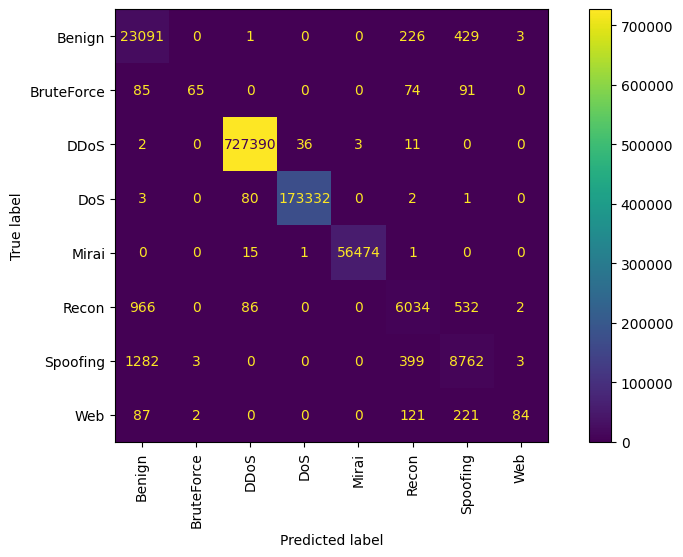

In [64]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier())
])

test_model(*baseline_df, model)

# Model

In [68]:
model_df = get_train_test_split(
    df_refined.sample(2_000_000),
    refined_features_list,
    target='general_label',
    train_frac=0.50
)

In [73]:
def get_attack_map(attack_category, layer_attacks):
    return {
        attack: attack if attack in layer_attacks else 'Benign'
        for attack in attack_category
    }

## First Layer - DDoS / DoS / Mirai

In [80]:
first_layer = {'DDoS', 'DoS', 'Mirai'}

first_layer_map = get_attack_map(attack_category, first_layer)

Training dataset size: 1.0M (50.0%).
Test dataset size: 1.0M (50.0%).
Execution time (Model fit): 0:02:20.231364
Execution time (Predict): 0:00:11.431362
              precision    recall  f1-score   support

      Benign      0.999     0.998     0.999     42649
        DDoS      1.000     1.000     1.000    727442
         DoS      1.000     0.999     1.000    173418
       Mirai      1.000     1.000     1.000     56491

    accuracy                          1.000   1000000
   macro avg      1.000     0.999     0.999   1000000
weighted avg      1.000     1.000     1.000   1000000



Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())])

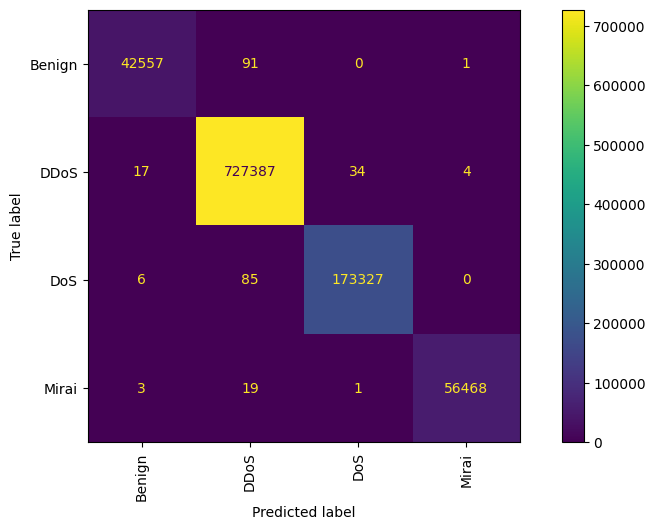

In [81]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier())
])

test_model(*baseline_df, model, attack_map=first_layer_map)

## Second Layer - Spoofing / Recon / Web / Brute Force

In [101]:
second_layer = {'Spoofing', 'Recon', 'Web', 'BruteForce'}

df_second_layer = get_train_test_split(
    df_refined[df_refined['general_label'].isin(second_layer | {'Benign'})],
    refined_features_list,
    target='general_label',
    train_frac=0.80
)

Training dataset size: 1.6M (80.0%).
Test dataset size: 395.4k (20.0%).
Execution time (Model fit): 0:25:39.120052
Execution time (Predict): 0:00:28.566694
              precision    recall  f1-score   support

      Benign      0.929     0.980     0.954    219566
  BruteForce      0.993     0.609     0.755      2616
       Recon      0.912     0.861     0.886     70611
    Spoofing      0.928     0.880     0.904     97793
         Web      0.975     0.524     0.681      4846

    accuracy                          0.926    395432
   macro avg      0.947     0.771     0.836    395432
weighted avg      0.927     0.926     0.925    395432



Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())])

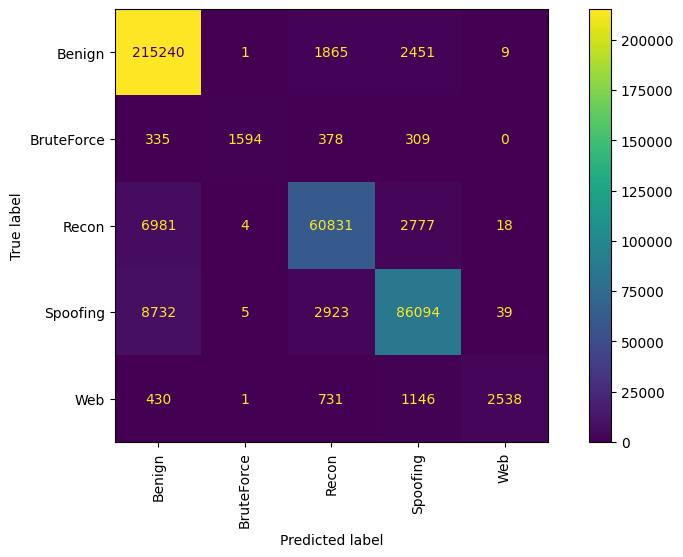

In [102]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier())
])

test_model(*df_second_layer, model)

### Test

Training dataset size: 1.6M (80.0%).
Test dataset size: 395.4k (20.0%).
Execution time (Model fit): 0:17:22.275095
Execution time (Predict): 0:00:08.917984
              precision    recall  f1-score   support

      Benign      0.883     0.986     0.932    219566
  BruteForce      1.000     0.247     0.397      2616
       Recon      0.903     0.806     0.852     70611
    Spoofing      0.924     0.809     0.863     97793
         Web      1.000     0.227     0.369      4846

    accuracy                          0.896    395432
   macro avg      0.942     0.615     0.682    395432
weighted avg      0.899     0.896     0.890    395432



Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier(max_depth=12))])

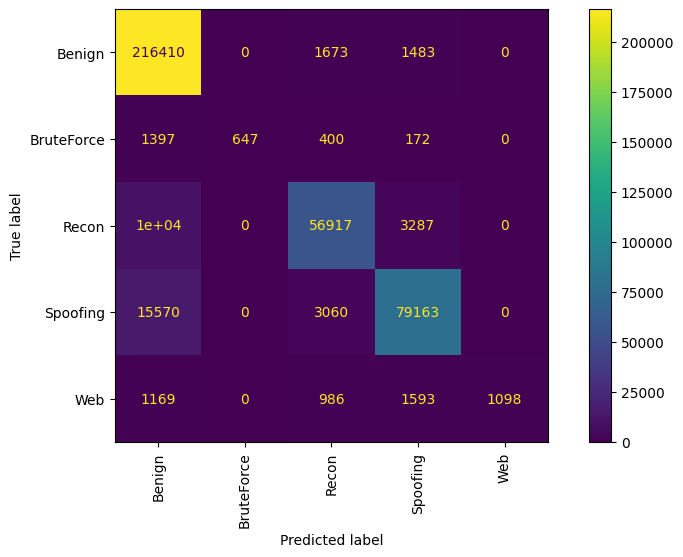

In [135]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(max_depth=12))
])

test_model(*df_second_layer, model)